In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from datetime import datetime

import tensorflow as tf
from scipy.optimize import minimize
from scipy.stats import gaussian_kde

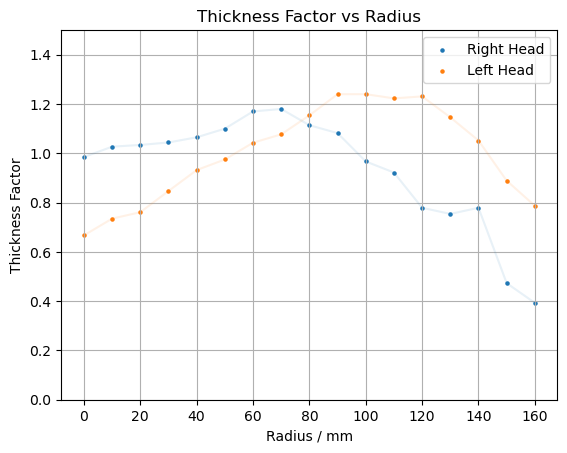

In [2]:
# Import data
df = pd.read_csv('data/plasma/PS0589.csv') # Right head
dfnp1 = df.to_numpy()
df = pd.read_csv('data/plasma/PS0592.csv') # Left head
dfnp2 = df.to_numpy()

if not np.array_equal(dfnp1[:,0], dfnp2[:,0]):
    raise ValueError('Radii do not match')
radii = dfnp1[:,0]
MAX_RADIUS = np.max(radii)

# Normalise radii
radii_norm = radii / MAX_RADIUS
thickness_factors1 = dfnp1[:,1]
thickness_factors2 = dfnp2[:,1]

# Extract pitch and roll
pitch1 = dfnp1[:,2][0]
pitch2 = dfnp2[:,2][0]
roll1 = dfnp1[:,3][0]
roll2 = dfnp2[:,3][0]

# Plot data
plt.scatter(radii, thickness_factors1, label='Right Head', s=5)
plt.scatter(radii, thickness_factors2, label='Left Head', s=5)
plt.plot(radii, thickness_factors1, alpha=0.1)
plt.plot(radii, thickness_factors2, alpha=0.1)
plt.xlabel('Radius / mm')
plt.ylabel('Thickness Factor')
plt.title('Thickness Factor vs Radius')
plt.ylim(0, 1.5)
plt.legend()
plt.grid()
plt.show()


#### Fit the data

In [3]:
X_train = []
for i in range(len(radii_norm)):
    X_train += [[radii_norm[i], pitch1, roll1]]
for i in range(len(radii_norm)):
    X_train += [[radii_norm[i], pitch2, roll2]]
X_train = np.array(X_train)
print(f'X_train.shape = {X_train.shape}')

y_train = np.append(thickness_factors1, thickness_factors2)
print(f'y_train.shape = {y_train.shape}')

X_train.shape = (34, 3)
y_train.shape = (34,)


In [4]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='gelu', input_shape=(3,)),
    tf.keras.layers.Dense(32, activation='gelu'),
    tf.keras.layers.Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               512       
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Train the model
history = model.fit(X_train, y_train, epochs=17500, verbose=0)

In [4]:
# Load model instead
model = tf.keras.models.load_model('models/plasma/model-230629-1238.h5')

In [5]:
# Define curve function
def get_tf(r, pitch, roll):
    r_norm = r/MAX_RADIUS
    pitch_ = pitch*np.ones_like(r_norm)
    roll_ = roll*np.ones_like(r_norm)
    X_test = np.column_stack((r_norm, pitch_, roll_))
    y_test = model.predict(X_test)
    return np.squeeze(y_test)

In [6]:
# Save the model
optional_desc = ''
dt = datetime.now().strftime('%y%m%d-%H%M')
if optional_desc == '':
    optional_desc = 'model'
model_path = f'models/plasma/{optional_desc}-{dt}.h5'
model.save(model_path)

#### Plot the results

16/16 [==============================] - 0s 2ms/step


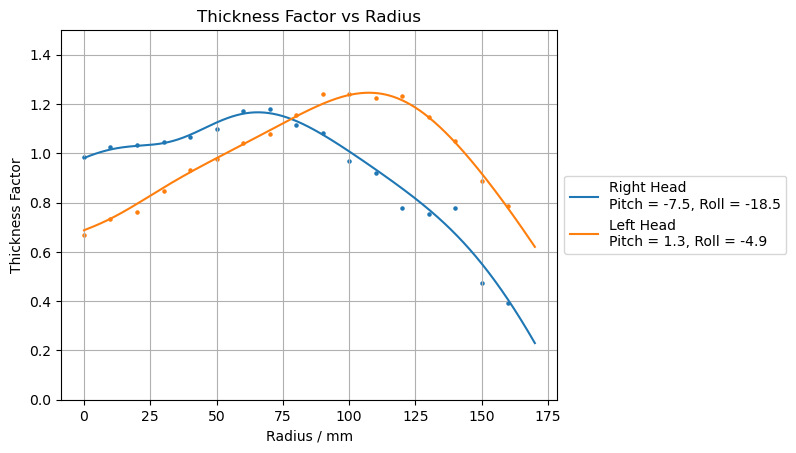

In [7]:
# Plot the results
radii_ = np.linspace(0, 170, 500)
tf1 = get_tf(radii_, pitch1, roll1)
tf2 = get_tf(radii_, pitch2, roll2)

plt.plot(radii_, tf1, color='C0', label=f'Right Head\nPitch = {pitch1}, Roll = {roll1}')
plt.plot(radii_, tf2, color='C1', label=f'Left Head\nPitch = {pitch2}, Roll = {roll2}')
plt.scatter(radii, thickness_factors1, s=5, color='C0')
plt.scatter(radii, thickness_factors2, s=5, color='C1')
plt.xlabel('Radius / mm')
plt.ylabel('Thickness Factor')
plt.title('Thickness Factor vs Radius')
plt.ylim(0, 1.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.show()

#### Thickness map visualisation

In [8]:
# Load plate geometry
with open('tapejig/plate_dims.txt', 'r') as f:
    plate_dims = f.readlines()
plate_dims = [float(x) for x in plate_dims]

PLATE_X = plate_dims[0]
PLATE_Y = plate_dims[1]
CENTER_X = PLATE_X / 2
CENTER_Y = PLATE_Y / 2

313/313 [==============================] - 0s 1ms/step


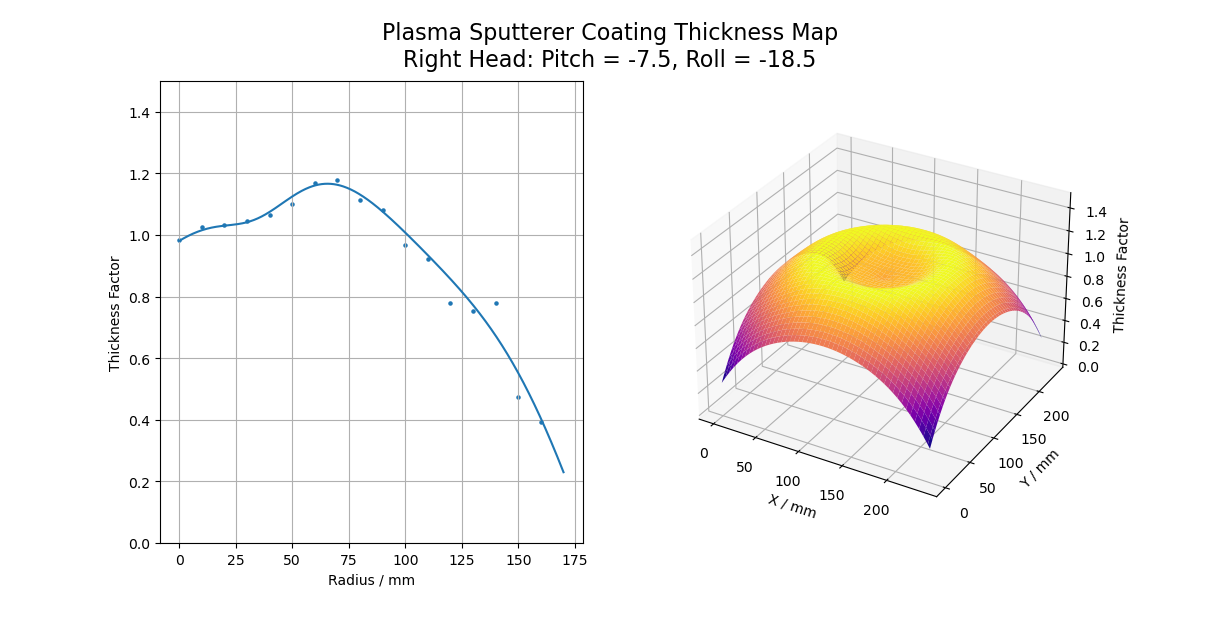

313/313 [==============================] - 1s 2ms/step


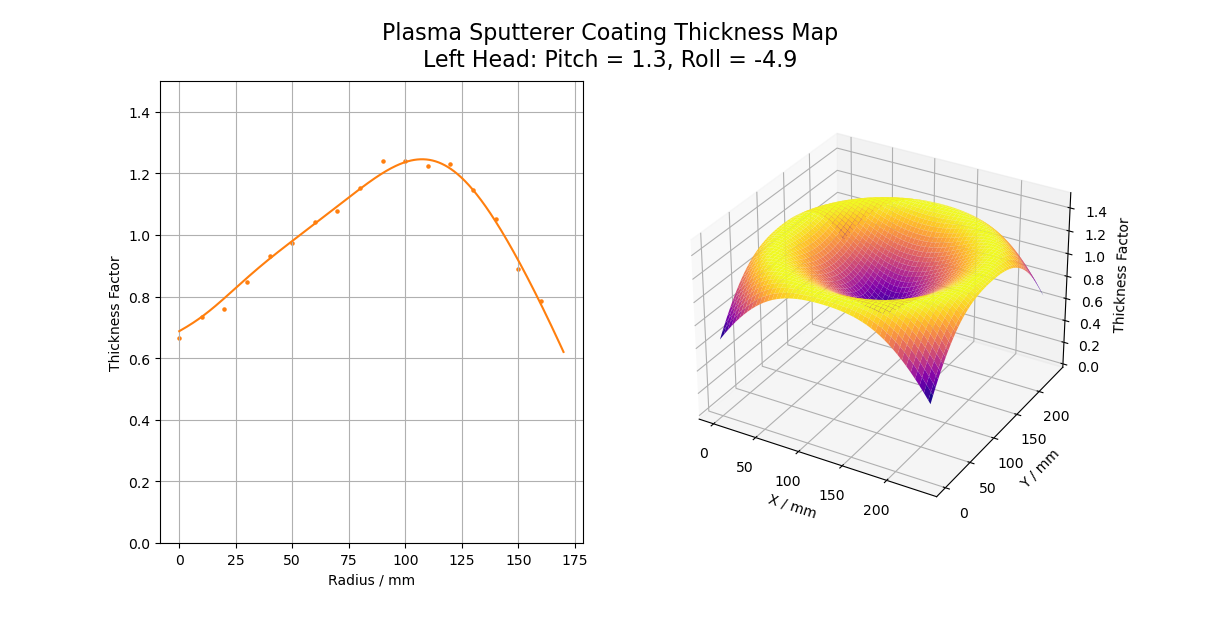

In [9]:
# Plot 1st profile in 3D
x_ = np.linspace(0, PLATE_X, 100)
y_ = np.linspace(0, PLATE_Y, 100)
xx_, yy_ = np.meshgrid(x_, y_)

rr_ = np.ravel(np.sqrt((xx_ - CENTER_X)**2 + (yy_ - CENTER_Y)**2)) # radius map
rr_ = np.ravel(rr_)
zz_ = get_tf(rr_, pitch1, roll1) # thickness factor map
zz_ = np.reshape(zz_, xx_.shape)

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], projection='3d')

ax1.plot(radii_, tf1, color='C0')
ax1.scatter(radii, thickness_factors1, s=5, color='C0')
ax1.set_xlabel('Radius / mm')
ax1.set_ylabel('Thickness Factor')
ax1.set_ylim(0, 1.5)
ax1.grid()

ax2.plot_surface(xx_, yy_, zz_, cmap='plasma', edgecolor='none')
ax2.set_xlabel('X / mm')
ax2.set_ylabel('Y / mm')
ax2.set_zlabel('Thickness Factor')
ax2.set_zlim(0, 1.5)

fig.suptitle(f'Plasma Sputterer Coating Thickness Map\nRight Head: Pitch = {pitch1}, Roll = {roll1}', fontsize=16)
fig.add_axes([0,0,1,1]).axis("off")
plt.show()

# Plot 2nd profile in 3D
x_ = np.linspace(0, PLATE_X, 100)
y_ = np.linspace(0, PLATE_Y, 100)
xx_, yy_ = np.meshgrid(x_, y_)

rr_ = np.ravel(np.sqrt((xx_ - CENTER_X)**2 + (yy_ - CENTER_Y)**2)) # radius map
rr_ = np.ravel(rr_)
zz_ = get_tf(rr_, pitch2, roll2) # thickness factor map
zz_ = np.reshape(zz_, xx_.shape)

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], projection='3d')

ax1.plot(radii_, tf2, color='C1')
ax1.scatter(radii, thickness_factors2, s=5, color='C1')
ax1.set_xlabel('Radius / mm')
ax1.set_ylabel('Thickness Factor')
ax1.set_ylim(0, 1.5)
ax1.grid()

ax2.plot_surface(xx_, yy_, zz_, cmap='plasma', edgecolor='none')
ax2.set_xlabel('X / mm')
ax2.set_ylabel('Y / mm')
ax2.set_zlabel('Thickness Factor')
ax2.set_zlim(0, 1.5)

fig.suptitle(f'Plasma Sputterer Coating Thickness Map\nLeft Head: Pitch = {pitch2}, Roll = {roll2}', fontsize=16)
fig.add_axes([0,0,1,1]).axis("off")
plt.show()

#### Applying the model to the tape targets

In [10]:
# Load target radii from csv
df = pd.read_csv('tapejig/target_radii.csv')
n = np.array(df['Target Number'].values)
target_radii = np.array(df['Radius'].values)

6/6 [==============================] - 0s 997us/step
Number of targets within 0.85 and 1.15:   132/180
Mean: 1.036   Std: 0.083


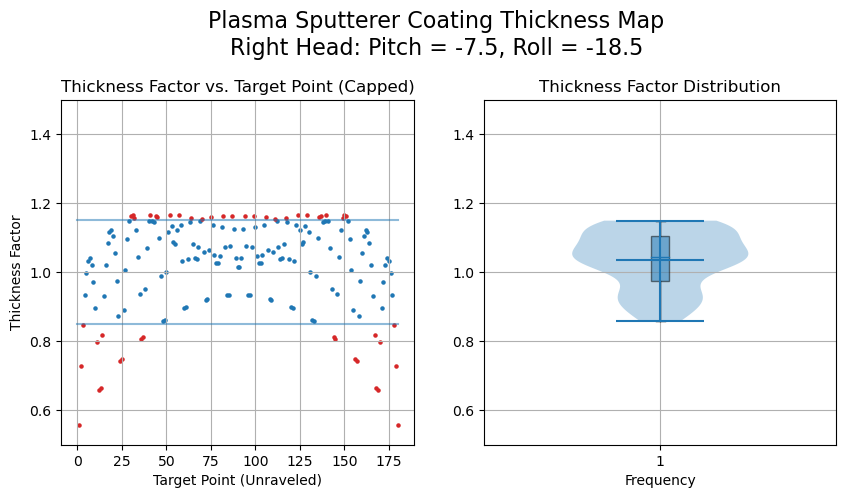

Number of targets within 0.85 and 1.15:   80/180
Mean: 1.023   Std: 0.087


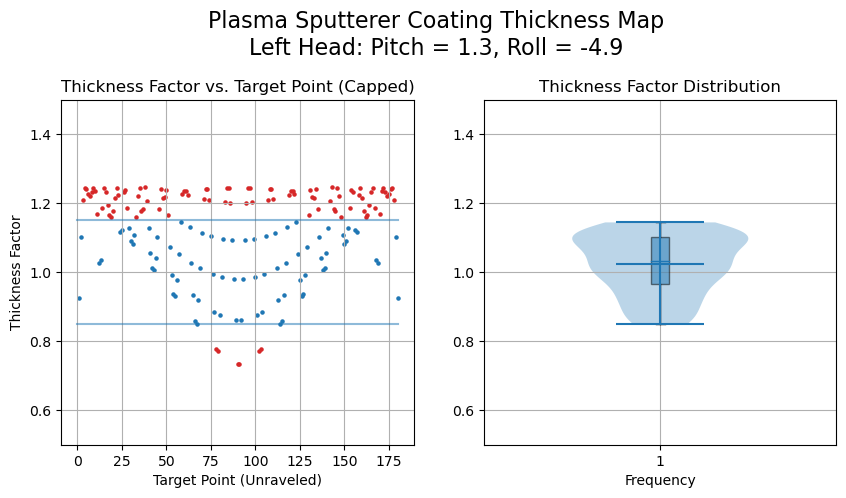

In [11]:
TF_FLOOR = 0.85
TF_CEILING = 1.15

# Get thickness factors
target_tf1 = get_tf(target_radii, pitch1, roll1)
target_tf2 = get_tf(target_radii, pitch2, roll2)

## Right Head ##
arg_ok = np.where((target_tf1 >= TF_FLOOR) & (target_tf1 <= TF_CEILING))[0]
arg_notok = np.where((target_tf1 < TF_FLOOR) | (target_tf1 > TF_CEILING))[0]

n_ok = n[arg_ok]
target_tfok1 = target_tf1[arg_ok]

n_notok = n[arg_notok]
target_tfnotok1 = target_tf1[arg_notok]

print(f"Number of targets within {TF_FLOOR} and {TF_CEILING}:   {len(arg_ok)}/180")
print(f'Mean: {np.mean(target_tfok1):.3f}   Std: {np.std(target_tfok1):.3f}')

# Plot the ok points
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot line to show the floor and ceiling
ax1.plot([0, 180], [TF_FLOOR, TF_FLOOR], c='C0', alpha=0.5)
ax1.plot([0, 180], [TF_CEILING, TF_CEILING], c='C0', alpha=0.5)
ax1.scatter(n_ok, target_tfok1, s=5)
ax1.scatter(n_notok, target_tfnotok1, s=5, c='C3')
ax1.set_xlabel('Target Point (Unraveled)')
ax1.set_ylabel('Thickness Factor')
ax1.set_ylim(0.5, 1.5)
ax1.set_title('Thickness Factor vs. Target Point (Capped)')
ax1.grid()

box = ax2.boxplot(target_tfok1, positions=[1], widths=0.05, patch_artist=True)
for patch in box['boxes']:
    patch.set_facecolor('C0')
    patch.set_alpha(0.5)
for median in box['medians']:
    median.set_color('C0')
ax2.violinplot(target_tfok1, showmeans=True)
ax2.set_xlim(0.5, 1.5)
ax2.set_ylim(0.5, 1.5)
ax2.set_xlabel('Frequency')
ax2.set_title('Thickness Factor Distribution')
ax2.grid()

fig.suptitle(f'Plasma Sputterer Coating Thickness Map\nRight Head: Pitch = {pitch1}, Roll = {roll1}', fontsize=16)
fig.subplots_adjust(top=0.80)
plt.show()


## Left Head ##
arg_ok = np.where((target_tf2 >= TF_FLOOR) & (target_tf2 <= TF_CEILING))[0]
arg_notok = np.where((target_tf2 < TF_FLOOR) | (target_tf2 > TF_CEILING))[0]

n_ok = n[arg_ok]
target_tfok2 = target_tf2[arg_ok]

n_notok = n[arg_notok]
target_tfnotok2 = target_tf2[arg_notok]

print(f"Number of targets within {TF_FLOOR} and {TF_CEILING}:   {len(arg_ok)}/180")
print(f'Mean: {np.mean(target_tfok2):.3f}   Std: {np.std(target_tfok2):.3f}')

# Plot the ok points
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot line to show the floor and ceiling
ax1.plot([0, 180], [TF_FLOOR, TF_FLOOR], c='C0', alpha=0.5)
ax1.plot([0, 180], [TF_CEILING, TF_CEILING], c='C0', alpha=0.5)
ax1.scatter(n_ok, target_tfok2, s=5)
ax1.scatter(n_notok, target_tfnotok2, s=5, c='C3')
ax1.set_xlabel('Target Point (Unraveled)')
ax1.set_ylabel('Thickness Factor')
ax1.set_ylim(0.5, 1.5)
ax1.set_title('Thickness Factor vs. Target Point (Capped)')
ax1.grid()

box = ax2.boxplot(target_tfok2, positions=[1], widths=0.05, patch_artist=True)
for patch in box['boxes']:
    patch.set_facecolor('C0')
    patch.set_alpha(0.5)
for median in box['medians']:
    median.set_color('C0')
ax2.violinplot(target_tfok2, showmeans=True)
ax2.set_xlim(0.5, 1.5)
ax2.set_ylim(0.5, 1.5)
ax2.set_xlabel('Frequency')
ax2.set_title('Thickness Factor Distribution')
ax2.grid()

fig.suptitle(f'Plasma Sputterer Coating Thickness Map\nLeft Head: Pitch = {pitch2}, Roll = {roll2}', fontsize=16)
fig.subplots_adjust(top=0.80)
plt.show()

In [12]:
# Export data as df in csv
df = pd.DataFrame({'Target Number': n, 'Thickness Factor': target_tf1})
df.to_csv('exports/plasma_right_only.csv', index=False)

# Export data as df in csv
df = pd.DataFrame({'Target Number': n, 'Thickness Factor': target_tf2})
df.to_csv('exports/plasma_left_only.csv', index=False)

#### Combined heads analysis
The section aims to find the optimal ratio of running time of the two heads. The first method is to find the ratio that minimises the flatness across the entire plane.

Optimization terminated successfully.
         Current function value: 0.028237
         Iterations: 28
         Function evaluations: 56
55/55 [==============================] - 0s 2ms/step


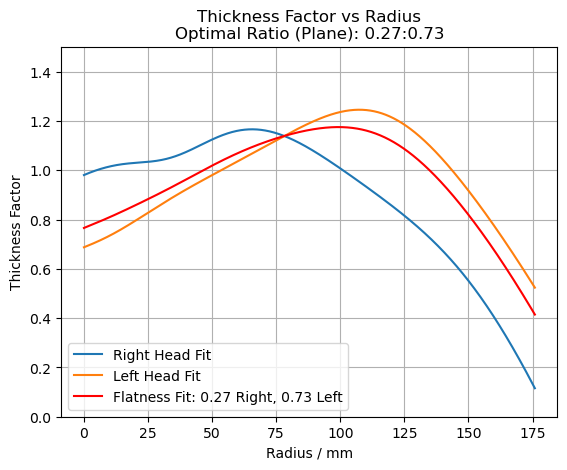

In [13]:
# Minimise flatness
def objective(ratio):
    tfs = ratio*tf1 + (1-ratio)*tf2
    mse = np.mean((tfs - 1)**2)
    return mse

res = minimize(objective, 0.5, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
r_optp = res.x[0]

def get_tfs(r, ratio):
    tfs = ratio*get_tf(r, pitch1, roll1) + (1-ratio)*get_tf(r, pitch2, roll2)
    return np.squeeze(tfs)

# Plot flatness
radii_ = np.arange(0, 176, 0.1)
tf1 = get_tf(radii_, pitch1, roll1)
tf2 = get_tf(radii_, pitch2, roll2)
tfs = get_tfs(radii_, r_optp)

plt.plot(radii_, tf1, label='Right Head Fit')
plt.plot(radii_, tf2, label='Left Head Fit')
plt.plot(radii_, tfs, label=f'Flatness Fit: {res.x[0]:.2f} Right, {1-res.x[0]:.2f} Left', c='r')
plt.xlabel('Radius / mm')
plt.ylabel('Thickness Factor')
plt.ylim(0, 1.5)
plt.title(f'Thickness Factor vs Radius\nOptimal Ratio (Plane): {r_optp:.2f}:{1-r_optp:.2f}')
plt.legend()
plt.grid()
plt.show()

6/6 [==============================] - 0s 2ms/step
Number of targets within 0.85 and 1.15:   104/180
Mean: 1.058   Std: 0.075


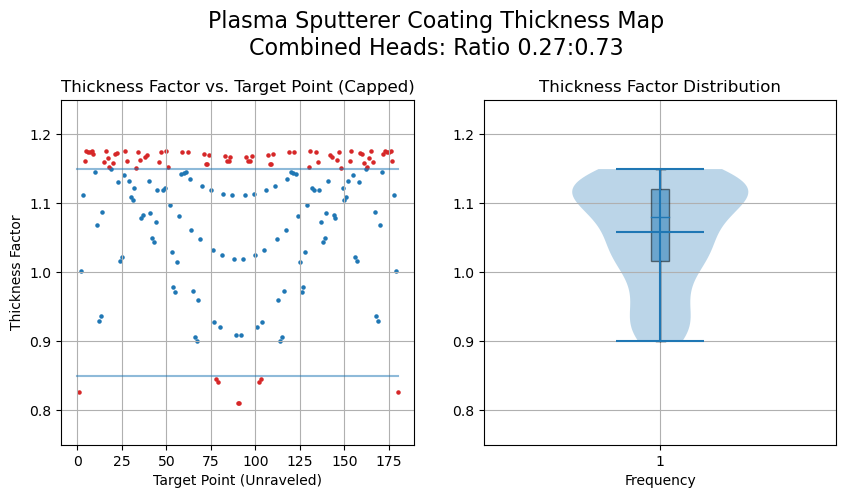

In [14]:
TF_CEILING = 1.15
TF_FLOOR = 0.85

## Combined Heads ##
target_tfs = get_tfs(target_radii, r_optp)

arg_ok = np.where((target_tfs >= TF_FLOOR) & (target_tfs <= TF_CEILING))[0]
arg_notok = np.where((target_tfs < TF_FLOOR) | (target_tfs > TF_CEILING))[0]

n_ok = n[arg_ok]
target_tfoks = target_tfs[arg_ok]

n_notok = n[arg_notok]
target_tfnotoks = target_tfs[arg_notok]

print(f"Number of targets within {TF_FLOOR} and {TF_CEILING}:   {len(arg_ok)}/180")
print(f'Mean: {np.mean(target_tfoks):.3f}   Std: {np.std(target_tfoks):.3f}')

# Plot the ok points
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot line to show the floor and ceiling
ax1.plot([0, 180], [TF_FLOOR, TF_FLOOR], c='C0', alpha=0.5)
ax1.plot([0, 180], [TF_CEILING, TF_CEILING], c='C0', alpha=0.5)
ax1.scatter(n_ok, target_tfoks, s=5)
ax1.scatter(n_notok, target_tfnotoks, s=5, c='C3')
ax1.set_xlabel('Target Point (Unraveled)')
ax1.set_ylabel('Thickness Factor')
ax1.set_ylim(0.75, 1.25)
ax1.set_title('Thickness Factor vs. Target Point (Capped)')
ax1.grid()

box = ax2.boxplot(target_tfoks, positions=[1], widths=0.05, patch_artist=True)
for patch in box['boxes']:
    patch.set_facecolor('C0')
    patch.set_alpha(0.5)
for median in box['medians']:
    median.set_color('C0')
ax2.violinplot(target_tfoks, showmeans=True)
ax2.set_xlim(0.5, 1.5)
ax2.set_ylim(0.75, 1.25)
ax2.set_xlabel('Frequency')
ax2.set_title('Thickness Factor Distribution')
ax2.grid()

fig.suptitle(f'Plasma Sputterer Coating Thickness Map\nCombined Heads: Ratio {r_optp:.2f}:{1-r_optp:.2f}', fontsize=16)
fig.subplots_adjust(top=0.80)
plt.show()

As optimising the flatness for entire plane does not necessarily optimise the flatness of the individual targets, the second method is to find the ratio that minimises the flatness and variance of the individual targets. We first visualise the flatness and variance of the individual targets for some ratios. Then we find the ratio that minimises the flatness and variance of the individual targets.

6/6 [==============================] - 0s 2ms/step


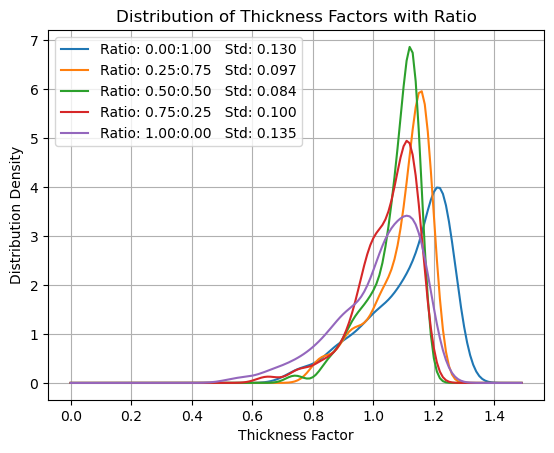

In [15]:
# Get distribution of thickness factors
for i in np.arange(0, 1.25, 0.25):
    kde_tf = gaussian_kde(get_tfs(target_radii, i))
    std = np.std(get_tfs(target_radii, i))
    tfn = np.arange(0, 1.5, 0.01)
    plt.plot(tfn, kde_tf(tfn), label=f'Ratio: {i:.2f}:{1-i:.2f}   Std: {std:.3f}')
plt.xlabel('Thickness Factor')
plt.ylabel('Distribution Density')
plt.title('Distribution of Thickness Factors with Ratio')
plt.legend()
plt.grid()
plt.show()

6/6 [==============================] - 0s 1ms/step
Optimization terminated successfully.
         Current function value: 0.084175
         Iterations: 29
         Function evaluations: 58
Optimal Ratio: 0.48445
6/6 [==============================] - 0s 997us/step


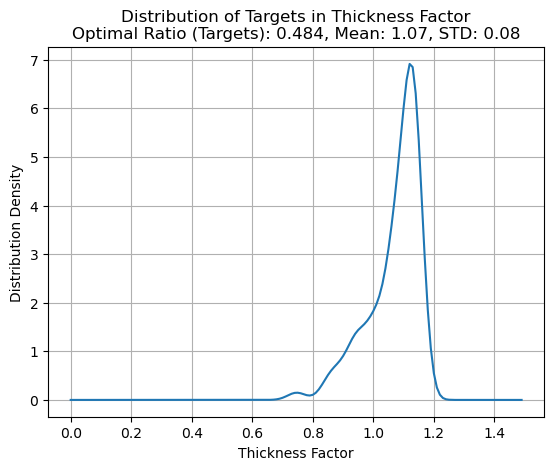

55/55 [==============================] - 0s 1ms/step


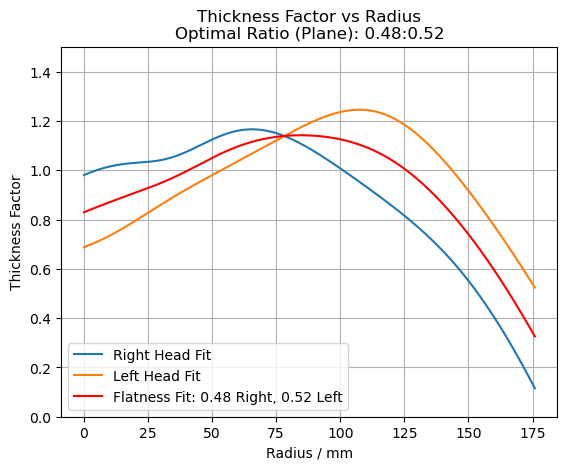

In [16]:
# Minimum standard deviation
def objective(ratio):
    tfs = get_tfs(target_radii, ratio)
    std = np.std(tfs)
    return std

res = minimize(objective, 0.2, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})
r_opt = res.x[0]
print(f'Optimal Ratio: {r_opt:.5f}')

kde_tf = gaussian_kde(get_tfs(target_radii, r_opt))
median = np.median(get_tfs(target_radii, r_opt))
mean = np.mean(get_tfs(target_radii, r_opt))
std = np.std(get_tfs(target_radii, r_opt))

tfn = np.arange(0, 1.5, 0.01)
plt.plot(tfn, kde_tf(tfn))
plt.xlabel('Thickness Factor')
plt.ylabel('Distribution Density')
plt.title('Distribution of Targets in Thickness Factor\n' + f'Optimal Ratio (Targets): {r_opt:.3f}, Mean: {mean:.2f}, STD: {std:.2f}')
plt.grid()
plt.show()

# Plot flatness
radii_ = np.arange(0, 176, 0.1)
tf1 = get_tf(radii_, pitch1, roll1)
tf2 = get_tf(radii_, pitch2, roll2)
tfs = get_tfs(radii_, r_opt)

plt.plot(radii_, tf1, label='Right Head Fit')
plt.plot(radii_, tf2, label='Left Head Fit')
plt.plot(radii_, tfs, label=f'Flatness Fit: {res.x[0]:.2f} Right, {1-res.x[0]:.2f} Left', c='r')
plt.xlabel('Radius / mm')
plt.ylabel('Thickness Factor')
plt.ylim(0, 1.5)
plt.title(f'Thickness Factor vs Radius\nOptimal Ratio (Plane): {r_opt:.2f}:{1-r_opt:.2f}')
plt.legend()
plt.grid()
plt.show()

6/6 [==============================] - 0s 2ms/step
Number of targets within 0.85 and 1.15:   176/180
Mean: 1.074   Std: 0.074


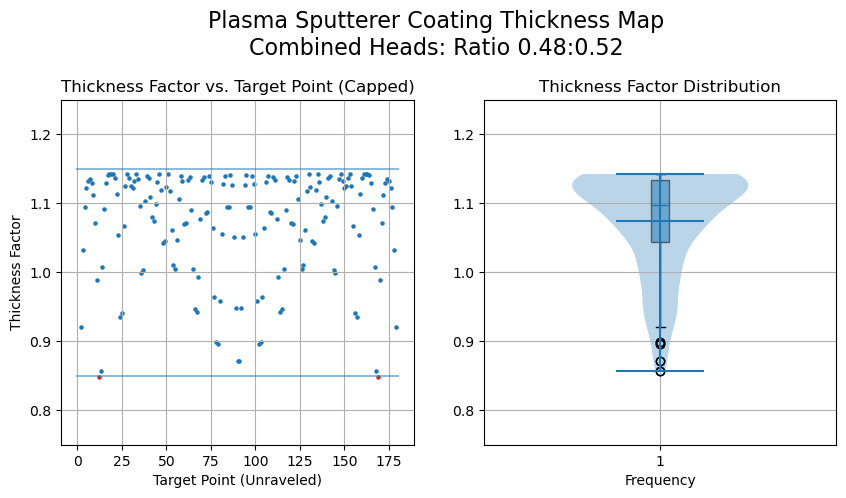

In [17]:
TF_CEILING = 1.15
TF_FLOOR = 0.85

## Combined Heads ##
target_tfs = get_tfs(target_radii, r_opt)

arg_ok = np.where((target_tfs >= TF_FLOOR) & (target_tfs <= TF_CEILING))[0]
arg_notok = np.where((target_tfs < TF_FLOOR) | (target_tfs > TF_CEILING))[0]

n_ok = n[arg_ok]
target_tfoks = target_tfs[arg_ok]

n_notok = n[arg_notok]
target_tfnotoks = target_tfs[arg_notok]

print(f"Number of targets within {TF_FLOOR} and {TF_CEILING}:   {len(arg_ok)}/180")
print(f'Mean: {np.mean(target_tfoks):.3f}   Std: {np.std(target_tfoks):.3f}')

# Plot the ok points
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot line to show the floor and ceiling
ax1.plot([0, 180], [TF_FLOOR, TF_FLOOR], c='C0', alpha=0.5)
ax1.plot([0, 180], [TF_CEILING, TF_CEILING], c='C0', alpha=0.5)
ax1.scatter(n_ok, target_tfoks, s=5)
ax1.scatter(n_notok, target_tfnotoks, s=5, c='C3')
ax1.set_xlabel('Target Point (Unraveled)')
ax1.set_ylabel('Thickness Factor')
ax1.set_ylim(0.75, 1.25)
ax1.set_title('Thickness Factor vs. Target Point (Capped)')
ax1.grid()

box = ax2.boxplot(target_tfoks, positions=[1], widths=0.05, patch_artist=True)
for patch in box['boxes']:
    patch.set_facecolor('C0')
    patch.set_alpha(0.5)
for median in box['medians']:
    median.set_color('C0')
ax2.violinplot(target_tfoks, showmeans=True)
ax2.set_xlim(0.5, 1.5)
ax2.set_ylim(0.75, 1.25)
ax2.set_xlabel('Frequency')
ax2.set_title('Thickness Factor Distribution')
ax2.grid()

fig.suptitle(f'Plasma Sputterer Coating Thickness Map\nCombined Heads: Ratio {r_opt:.2f}:{1-r_opt:.2f}', fontsize=16)
fig.subplots_adjust(top=0.80)
plt.show()

In [18]:
# Export data as df in csv
df = pd.DataFrame({'Target Number': n, 'Thickness Factor': target_tfs})
df.to_csv('exports/plasma_combined.csv', index=False)